# TP2: Convolutional Neural Networks in Pytorch

**Authors:** 
- tom.dupuis@centralesupelec.fr


If you have questions or suggestions, contact us and we will gladly answer and take into account your remarks.

For this tp you need to have some ground understanding of pytorch and basics introduction. It is available [here](https://pytorch.org/tutorials/beginner/basics/intro.html).


## Objective

In this TP, we will implement Convolutional Neural Networks (CNNs) to classify correctly images for the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

The CIFAR-10 dataset consists of 60 000 32x32 colour images in 10 classes, with 6 000 images per class. There are 50 000 training images and 10 000 test images.

We will first design a custom made CNN using Pytorch to make the classification and then use an architecture available from torchvision that we will either train from scratch or finetune.

We will compare the accuracy on the test set for all networks.

Finally, we will also make use of Data Augmentation to further improve the generalization of our custom model to the testing data.

Follow the TP sequentially, otherwise you could spoil yourself answers of the first part :) 

## Your task

Fill the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE)

## Custom Made CNN

Our networks will be implemented as follows:

  - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
  - a ReLu activation function

  - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
  - a ReLu activation function
  - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)

  - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
  - a ReLu activation function
  - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)

  - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)

  - a Fully-Connected layer of output size 10


We will optimize it using the SGD optimizer with $lr = 0.01$, $momentum = 0.9$ and the cross-entropy loss.

In this TP, in order to speed-up computations, we will use the GPU, so do not forget [to put on GPU](https://pytorch.org/docs/stable/notes/cuda.html) every objects required, we will remind you when it is needed.


### Load dataset

To load the dataset, refer to the [pytorch documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html).

You will need to pass a [transform](https://pytorch.org/vision/stable/transforms.html) to the dataset to perform these operations:
- Transform the image to Tensor
- Normalize the data according to CIFAR10 statistics

These transforms are available from the link above.

You will also need a train and a test [dataloaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to iterate over the training and testing datasets. To configure the dataloader here is what to know:
- We will use a batch size of 128.
- Only training data needs to be shuffled to avoid learning the order of data.
- Colab has two cpus so the number of workers needs to be inferior or equal to 2.
- Drop the last batch only for training data.

Because Colab provides us few resources, we will also downsample our datasets to perform quicker experiments and not just wait for completion of cells.

In [1]:
import numpy as np
from math import floor
from torch.utils.data import Subset

def downsample_cifar10_dataset(dataset, percentage, seed=42):
  """
  Downsample the given dataset by only keeping a percentage of data.

  Args:
    dataset: The dataset to downsample.
    percentage: The percentage of data to keep.
    seed: The seed to configure the random subset choice.
  """
  rng = np.random.default_rng(seed)

  index_to_keep = []
  for class_idx in range(len(dataset.class_to_idx)):
    class_mask = [target == class_idx for target in dataset.targets]
    indices_class = [i for i, x in enumerate(class_mask) if x]
    index_to_keep.extend(np.random.choice(indices_class, floor(percentage * len(indices_class)), replace=False))
  
  return Subset(dataset, index_to_keep)

In [3]:
from torch.utils.data import DataLoader

# --- START CODE HERE(01)
# Import the dataset
# Import the classes of the transform to apply on input data
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
# --- END CODE HERE

idx_to_class = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

mean_cifar=[0.491, 0.482, 0.446]
std_cifar=[0.247, 0.243, 0.261]

# --- START CODE HERE (02)
# Intantiate the transform and the datasets for training and testing
transform = v2.Compose([v2.ToTensor(), v2.Normalize(mean_cifar, std_cifar)])
dataset_train = CIFAR10(root="./data", train=True, transform=transform, download=True)
dataset_test = CIFAR10(root="./data", train=False, transform=transform, download=True)
# --- END CODE HERE

dataset_train = downsample_cifar10_dataset(dataset_train, percentage=0.2)
dataset_test = downsample_cifar10_dataset(dataset_test, percentage=0.2)

# --- START CODE HERE (03)
# Intantiate the dataloaders for training and testing
train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=64, shuffle=True)
# --- END CODE HERE

100%|██████████| 170498071/170498071 [00:15<00:00, 11013541.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Visualize the data

Below you can visualize various images from the CIFAR10 dataset.

Shape of train images: torch.Size([3, 32, 32]).
Labels:
['bird', 'horse', 'horse', 'ship', 'horse', 'frog', 'truck', 'ship', 'automobile', 'horse', 'deer', 'truck', 'cat', 'ship', 'ship', 'horse'].

Grid of train images:


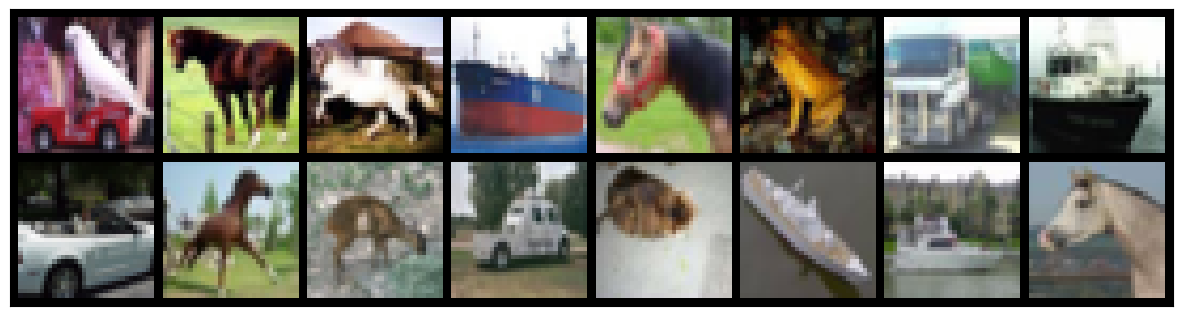

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

def show(imgs):
  """
  Show input images.

  Args:
    imgs: the images to show
  """

  if not isinstance(imgs, list):
    imgs = [imgs]
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(15, 15))
  for i, img in enumerate(imgs):
    img = img.detach()
    img = F.to_pil_image(img)
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def denormalize_tensor(tensor, mean, std):
  """
  Denormalize a tensor.

  Args:
    tensor: the tensor to denormalize.
    mean: the mean that normalized.
    std: the std that normalized.
  """
  
  mean = torch.tensor(mean).view((1, 3, 1, 1))
  std = torch.tensor(std).view((1, 3, 1 , 1))
  return tensor * std + mean

random_train_samples = [dataset_train[idx] for idx in np.random.choice(len(dataset_train), 16)]
random_train_X = torch.stack([sample[0] for sample in random_train_samples])
random_train_y = [idx_to_class[sample[1]] for sample in random_train_samples]
train_grid = make_grid(denormalize_tensor(random_train_X, mean_cifar, std_cifar))

print(f"Shape of train images: {random_train_X[0].shape}.")
print(f"Labels:\n{random_train_y}.\n")
print(f"Grid of train images:")
show(train_grid)

### Implement custom model

Here, we will implement the custom model following the [Sequential model](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) from Pytorch.

You will need to feed to the Sequential model the layers that define your model. These layers must follow the architecture detailed above. The various layers required are available in Pytorch and can be found in the Neural Network, or [nn](https://pytorch.org/docs/stable/nn.html), package

In [5]:
# --- START CODE HERE (04)
# Import the layers to implement the model
from torch import nn
from torch.nn import functional as F

# --- END CODE HERE

def make_custom_model(): # Function in case you need to reinitialize model.
  """
  Make the custom model.
  """

  layers = [
    # --- START CODE HERE (05)
    # Instantiate the various layers composing our model.
    # Convolutional layers: 32 filters, kernel size 3, stride 1, padding 'same'
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"),
    # ReLU activation
    nn.ReLU(),
    # Convolutional layers: 32 filters, kernel size 3, stride 1, padding 'same'
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding="same"),
    # ReLU activation
    nn.ReLU(),
    # Max pooling layer: kernel size 2, stride 2
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Convolutional layers: 32 filters, kernel size 3, stride 1, padding 'same'
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding="same"),
    # ReLU activation
    nn.ReLU(),
    # Max pooling layer: kernel size 2, stride 2
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flatten layer
    nn.Flatten(),
    # Fully connected layer: 10 output units
    nn.Linear(in_features=32*8*8, out_features=10) 
    # --- END CODE HERE
 ]

  # --- START CODE HERE (06)
  # Feed the layers to the Sequential class.
  model = nn.Sequential(*layers)
  # --- END CODE HERE
  return model

model = make_custom_model()
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=2048, out_features=10, bias=True)
)

### Train custom model

#### Helper functions

We define several helper functions to compute the accuracy, and display the loss and accuracy to visualize our trainings.

In [6]:
def display_losses_and_accuracies(train_loss, test_loss, train_accuracy, test_accuracy):
  """
  Display the training and testing loss and accuracies.

  Args:
    train_loss: the training loss list.
    test_loss: the testing loss list.
    train_accuracy: the training accuracy list.
    test_accuracy: the testing accuracy list.
  """

  plt.subplot(1,2,1)
  plt.plot(train_loss, 'r')
  plt.plot(test_loss, 'g--')
  plt.xlabel('# epoch')
  plt.ylabel('loss')
  plt.grid(True)

  plt.subplot(1,2,2)
  plt.plot(train_accuracy, 'r')
  plt.plot(test_accuracy, 'g--')
  plt.xlabel('# epoch')
  plt.ylabel('accuracy')
  plt.grid(True)
  plt.show()


def F_computeAccuracy(preds, y):
    """Compute the accuracy
    
    Parameters
    ----------
    preds: (m, 1)
        predicted value by the MLP
    y: (m, 1)
        ground-truth class to predict
    """
    
    m = y.shape[0]
    if preds.shape[1] == 1:
      hard_preds = (preds > 0.5).to(torch.int64)
    else:
      hard_preds = (torch.argmax(preds, 1)).to(torch.int64)
    return torch.sum(hard_preds==y) / m

#### Training loop

To reuse our training loop, we will define a function that takes as an argument:
- the model
- the loss function
- the optimizer
- the training and testing dataloaders
- the number of epochs to perform.

In this loop, you will take care of 
- making the iterator over the dataloaders
- [putting on the cuda device](https://pytorch.org/docs/stable/notes/cuda.html) the batch of data for training and testing

The rest of the loop is the same as for the first TP:
- computation of the predictions by passing through the models
- loss computation based on predictions and targets
- accuracy computation and metrics storage

In [7]:
import torch.cuda

def training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs):
  train_loss_epoch, train_accuracy_epoch = [], []
  test_loss_epoch, test_accuracy_epoch = [], []

  if torch.cuda.is_available():
    cuda = torch.device('cuda')
    model = model.to(cuda)
    print(f"Training on {cuda} device.")
  else:
    print("Training on CPU.")

  for nb_epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_iter, train_accuracy_iter = [], []
    test_loss_iter, test_accuracy_iter = [], []

    # --- START CODE HERE (07)
    # Iterate over the train dataloader and put the batch data on cuda device.
    for t in train_dataloader:
      X, y = t
      X = X.to(cuda)
      y = y.to(cuda)
    # --- END CODE HERE

      # --- Forward
      train_preds = model(X)
      loss = loss_fn(train_preds, y)

      accuracy = F_computeAccuracy(train_preds, y)
      
      # --- Store results on train
      train_loss_iter.append(loss.item())
      train_accuracy_iter.append(accuracy)
      
      # --- Backward
      optimizer.zero_grad()
      loss.backward()
      
      # --- Update parameters
      optimizer.step()

    with torch.no_grad():
      model.eval()
      # --- START CODE HERE (08)
      # Iterate over the test dataloader and put the batch data on cuda device.
      for t in test_dataloader:
        X, y = t
        X = X.to(cuda)
        y = y.to(cuda)
        
      # --- END CODE HERE

        # --- Store results on test
        test_preds = model(X)
        loss = loss_fn(test_preds, y)
        accuracy = F_computeAccuracy(test_preds, y)
        test_loss_iter.append(loss.item())    
        test_accuracy_iter.append(accuracy)

    train_loss_epoch.append(torch.mean(torch.tensor(train_loss_iter)))  
    train_accuracy_epoch.append(torch.mean(torch.tensor(train_accuracy_iter)))  
    test_loss_epoch.append(torch.mean(torch.tensor(test_loss_iter)))  
    test_accuracy_epoch.append(torch.mean(torch.tensor(test_accuracy_iter)))  
    
    print("epoch: {0:d} (loss: train {1:.2f} test {2:.2f}) (accuracy: train {3:.2f} test {4:.2f})".format(num_epoch, train_loss_epoch[-1], test_loss_epoch[-1], train_accuracy_epoch[-1], test_accuracy_epoch[-1]))

  return train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch

Now that the dataloading, the model definition, and the training loop are done we can train our model.

Before that, we need to instantiate our optimizer and our loss function.
Also to speed-up training, as explained before, we will use the [cuda device](https://pytorch.org/docs/stable/notes/cuda.html), which is the GPU.

All modules should be put on the cuda device, so in our case:
- the model
- the loss function

In the training loop, we already took care of having the data on the cuda device so we will not encounter an error.

You should observe overfitting during training (low training loss and increasing testing loss). Later in the TP we will add data augmentations to reduce this issue.

In [8]:
# --- START CODE HERE (09)
# Import the loss and optimizer classes.
from torch import optim
from torch.nn import functional as F
# import loss
from torch.nn import CrossEntropyLoss
# --- END CODE HERE

# Run over epochs
nb_epoch = 20

model = make_custom_model()

# --- START CODE HERE (10)
# Put the model on cuda device and initialize the optimizer and the loss function to put on cuda aswell
# We will optimize it using the SGD optimizer with $lr = 0.01$, $momentum = 0.9$ and the cross-entropy loss.
cuda = torch.device('cuda')
model = model.to(cuda)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = CrossEntropyLoss()
# --- END CODE HERE

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch)

display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Train the CNN backbone ResNet-18


In this section, we will train a [ResNet-18](https://arxiv.org/pdf/1512.03385.pdf) model that has proven effective to classification tasks.

We will train in two different ways our ResNet-18:
 - we will simply take a ResNet-18 randomly initialized backbone and train it for a few epochs on CIFAR10.

 - we will instantiate a ResNet-18 that has first been pretrained on ImageNet and finetune it on CIFAR10 for a few epochs.


### Load data

The ResNet-18 architecture has been proposed to solve the ImageNet classification problem which has a large resolution in comparison of CIFAR10 (around 256x256 vs 32x32). 

The first part of ResNet is called stem and aims to reduce the dimension of the input. To properly make use of this backbone, we can either change the stem, or resize our input to match Imagenet. You can find the architecture implementation [here](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).

We will go for the latter as we will compare our randomly initialized backbone to the finetuned one that has to keep the same stem to properly initialized its weights.

Based on this requirement, we will define a new training and testing dataset transform that will be composed of:
- Resize the image to 224x224
- Transform the image to Tensor
- Normalize the data according to CIFAR10 statistics

In [ ]:
# --- START CODE HERE (11)
# Import the transform and instantiate the right transform.

# --- END CODE HERE

dataset_train = CIFAR10('.', train=True, transform=transform, download=True)
dataset_test = CIFAR10('.', train=False, transform=transform, download=True)

dataset_train = downsample_cifar10_dataset(dataset_train, percentage=0.2)
dataset_test = downsample_cifar10_dataset(dataset_test, percentage=0.2)

train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(dataset_test, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

### Instantiate the model

The ResNet model has been proposed to perform on the ImageNet dataset, therefore the last fully connected layer to make class prediction has an output dimension of 1000, which is the number of classes of ImageNet.

To properly use ResNet on CIFAR10, we must change this last fully connected layer to have an output dimension of 10. We will use the Torchvision [Resnet18 implementation](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

We also want to be able to instantiate a model that is initialized in two ways:
- Random: to perform training from scratch
- Pretrained: transfer learning from the ImageNet pretrained weights.

For transfer learning, we will have the choice to either finetune the whole backbone or only the last fully connected layer. The former generally provides better result as the whole backbone gets to specialize to the task but the latter has the advantage to require fewer computational resources, and is better for very small datasets.

For only training the last layer, we will have to inform Pytorch to not optimize other parameters. This can be done by iterating over the [parameters](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters) and changing their [requires_grad](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) value.

All these requirements need to be implemented in the function below.

In [ ]:
# --- START CODE HERE (12)
# Import the resnet model

# --- END CODE HERE

def get_resnet18(pretrained: bool = False, output_dim: int = 1000, only_train_fc: bool = False):
  if pretrained:
    weights = ResNet18_Weights.DEFAULT
  else:
    weights = None

  # --- START CODE HERE (13)
  # Configure the resnet model and update its fully connected layer
  
  # --- END CODE HERE

  if only_train_fc:
    # --- START CODE HERE (14)
    # Only keep the fully connected layer parameters trainable.
    
    pass
    # --- END CODE HERE

  return model

get_resnet18(False, 10)

### Train the randomly initialized ResNet-18 backbone

Use the previous function to instantiate the randomly initialized ResNet-18.

You should observe that the training loss keeps decreasing but the test performance seeems to reach some kind of plateau or decrease. This is an exemple of overfitting.

In [ ]:
# Run over epochs
nb_epoch = 10

# --- START CODE HERE (15)
# Instantiate the randomly initialised resnet18.
model = 
# --- END CODE HERE

# Initialize the optimizer and the loss function
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = CrossEntropyLoss().cuda()


train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch)

display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

### Transfer learning of a pretrained ResNet-18 backbone

In this section we will use the pretained ResNet-18 on Imagenet to perform either linear classifier training or finetuning of the whole backbone.

#### Linear classifier training

Instantiate the ResNet-18 with the ImageNet pretrained weights using the function we implemented but for training only the linear classifier.

You should observe a large improvement over random initialization.

In [ ]:
# Run over epochs
nb_epoch = 10

# --- START CODE HERE (16)
# Instantiate the pretrained resnet18 with only the fully connected layer trained.
model = 
# --- END CODE HERE

# Initialize the optimizer and the loss function
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = CrossEntropyLoss().cuda()

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch)

display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

#### Complete finutining

Instantiate the ResNet-18 with ImageNet pretrained weights using the function we implemented for training the whole backbone.

You should observe an improvement over linear classifier training.

In [ ]:
# Run over epochs
nb_epoch = 10

# --- START CODE HERE (17)
# Instantiate the pretrained resnet18 with the whole backbone trained.
model = 
# --- END CODE HERE

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = CrossEntropyLoss().cuda()

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch)

display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

## Data Augmentation

To improve the generalization of our model and reduce risk of overfitting on the data, we can make use of Data Augmentation.

The idea of Data Augmentation is to perform various transformations of our training data that enhance in some way the number of training data but also can make our representations invariant to various changes.

The most common data augmentations used for classification are:
- random resized crop: that randomly take a subpart of the image and resize the image to the input size
- random horizontal flip: that randomly flip the image horizontally

Some stronger augmentations have been used for either classification or self-supervised learning. Among them we can cite:
- color jittering: change the brightness, contrast, saturation and hue of an image
- gaussian blur: apply a gaussian kernel to the image
- grayscale or color dropping: lose color information of the image

All these augmentations are available in [Torchvison](https://pytorch.org/vision/stable/transforms.html).

### Data Augmentation visualization

We provide you the code to be able to visualize augmentations along with the raw images.

In [ ]:
def get_cifar_train_and_test_datasets(train_transform=None, test_transform=None, percentage=0.2):
  """
  Construct CIFAR train and test datasets.

  Args:
    train_transform: transform for training dataset
    test_transform: transform for testing dataset
    percentage: percentage of data to keep 
  """

  dataset_train = CIFAR10('.', train=True, transform=train_transform, download=True)
  dataset_test = CIFAR10('.', train=False, transform=test_transform, download=True)

  dataset_train = downsample_cifar10_dataset(dataset_train, percentage=percentage)
  dataset_test = downsample_cifar10_dataset(dataset_test, percentage=percentage)

  return dataset_train, dataset_test


def get_cifar_train_and_test_dataloaders(dataset_train, dataset_test, batch_size=128):
  """
  Construct CIFAR train and test dataloaders.

  Args:
    dataset_train: training dataset
    dataset_test: testing dataset
    batch_size: batch size for both dataloaders
  """

  train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
  test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

  return train_dataloader, test_dataloader


def visualize_transform(transform = ToTensor(), mandatory_transform = ToTensor(), nb_images_to_visualize = 10):
  """
  Visualize data augmentations and image before the data augmentation.
  
  Args:
    transform: transform to visualize (Optionaly a resize + other transforms)
    mandatory_transform: If transform contains resize, also give resize transform to correctly visualize the images.
    nb_images_to_visualize: The number of images to visualize.
  """

  dataset_train, _ = get_cifar_train_and_test_datasets(train_transform=None, test_transform=None)

  raw_images = [dataset_train[i][0] for i in range(nb_images_to_visualize)]
  transformed_images = [transform(image) for image in raw_images]
  transformed_images_mandatory = [mandatory_transform(image) for image in raw_images] if mandatory_transform is not None else raw_images

  transformed_images = torch.stack(transformed_images)
  transformed_images_mandatory = torch.stack(transformed_images_mandatory)

  grid = make_grid(torch.cat((transformed_images_mandatory, transformed_images)), nrow=nb_images_to_visualize)

  show(grid)

In [ ]:
from torchvision.transforms import ColorJitter 

transform = Compose([
    Resize(224),
    ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
    ToTensor()
])

resize_transform = Compose([
    Resize(224),
    ToTensor()
])

visualize_transform(transform, resize_transform)

### Train our custom CNN with Data Augmentations

Now, we will train our randomly initialized custom model with some new transforms.

The first set of data augmentation we will try is the common for classification:
- random horizontal flip: with a probability of 0.5

Then we will add [randomly](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomApply.html) color jittering and grayscale with the parameters:
- 0.8 probability to add color jitter
- 0.4 for brightness, contrast, saturation
- 0.1 for hue
- 0.2 probability to add grayscale

On top of these data augmentations, do not forget to transform the image to tensor and normalize the data according to CIFAR statistics.

You should observe that the data augmentations improve performance and reduce overfitting. However, to better see this, you might want to increase the number of epochs to train. Indeed, it is harder for the model to train with the data augmentations and the improvement is generally seen for longer training. Also the random initialization can be better for some configurations and the effect of better initialization is reduced for longer training.

#### Classical Data Augmentation

Train the custom CNN with the classical data augmentation, you should observe less overfitting than before.

In [ ]:
# --- START CODE HERE (18)
# Import the transforms and instantiate the classical set of data augmentation for classification.

train_transform = 
# --- END CODE HERE

test_transform = Compose([
    ToTensor(), 
    Normalize([0.491, 0.482, 0.446], [0.247, 0.243, 0.261])
])

dataset_train, dataset_test = get_cifar_train_and_test_datasets(train_transform=train_transform, test_transform=test_transform, percentage=0.2)
train_dataloader, test_dataloader = get_cifar_train_and_test_dataloaders(dataset_train, dataset_test, 128)

# Run over epochs
nb_epoch = 20

model = make_custom_model()
model.cuda()

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = CrossEntropyLoss().cuda()

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch)

display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

#### Stronger Data Augmentation

Train the custom CNN with the stronger data augmentation, you should observe less overfitting than the classical data augmentation and hopefully slightly better results. 

In [ ]:
# --- START CODE HERE (19)
# Import the transforms and instantiate the stronger set of data augmentation.

train_transform = 
# --- END CODE HERE

test_transform = Compose([
    ToTensor(), 
    Normalize([0.491, 0.482, 0.446], [0.247, 0.243, 0.261])
])

dataset_train, dataset_test = get_cifar_train_and_test_datasets(train_transform=train_transform, test_transform=test_transform, percentage=0.2)
train_dataloader, test_dataloader = get_cifar_train_and_test_dataloaders(dataset_train, dataset_test, 128)

# Run over epochs
nb_epoch = 20

model = make_custom_model()
model.cuda()

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = CrossEntropyLoss().cuda()

train_loss_epoch, train_accuracy_epoch, test_loss_epoch, test_accuracy_epoch = \
  training_loop(model, loss_fn, optimizer, train_dataloader, test_dataloader, nb_epoch)

display_losses_and_accuracies(train_loss_epoch, test_loss_epoch, train_accuracy_epoch, test_accuracy_epoch)

## BONUS

We tested various things using the Resnet backbone:
- training from random initialization
- finetuning the whole backbone or training the last layer

If you want to perform more tests, you can try to use differents backbones such as VGG, or look at data augmentations.

There are few parameters that you can also try to tune to improve performance such as:
- the batch size
- the optimizer
- the learning rate
- longer training

You can try to [visualize your learned kernel weights](https://github.com/utkuozbulak/pytorch-cnn-visualizations#convolutional-neural-network-filter-visualization).

Also you can have a look to various Kaggle competitions on Computer Vision !